### Reproduce Numerical error experiments

In [1]:
from itertools import chain
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from layers import ILeakyReLU

%matplotlib inline
plt.style.use("dark_background")

In [2]:
units = {"MiB":lambda x:x//2**20,
         None:lambda x:x}

distrib = {"normal"  : torch.randn,
           "uniform" : torch.rand}

def input_factory(bs=64, ch=64, dims=(128, 128), mu=0, sigma=1, dist="normal"):
    return ((distrib[dist]((bs, ch) + tuple(dims))*sigma) + mu).cuda()
        
f={
    "snr"    : lambda x: (x[0].std()**2/(x[0]-x[1]).std()**2).item(),
    "snr_"    : lambda x: ((x[1].var() - (x[0]-x[1]).var())/(x[0]-x[1]).std()**2).item(),
    "foo"    : lambda x: (x[0].std()/(x[0]-x[1]).std()).item(),
    "logsnr" : lambda x: 2*(torch.log10(x[0].std()) - torch.log10((x[0]-x[1]).std())).item(),
    "logfoo" : lambda x: 2*(torch.log10(x[0].std()) - torch.log10((x[0]-x[1]).std())).item(),
}
f_= f.keys()

In [3]:
ch  = 100
dim = 10
eps = 10**-8
eps_= 0
nlayer = 15
bs = 100
sigma = 1
mu = 0

invert = False 
neg_slope=.01
ieps = 0.001

# Leaky

In [11]:
f = {"snr" : lambda x: ((x[0]**2).mean()/((x[0]-x[1])**2).mean()).item()}
alpha = lambda phi: 4*((1 + phi**2) * (1 + 1/(phi**2)) )**-1
start,end = np.log10(10**-3), np.log10(10**3)
slopes = 10**np.linspace(start, end, 50)
ratio = 5

In [12]:
start,end = np.log10(10**-3), np.log10(10**3)
slopes = 10**np.linspace(start, end, 50)

mod = ILeakyReLU(invert=False)
noisy_rec = torch.cuda.FloatTensor(0)

in_snr = []
out_snr = []
ratio = 5
for neg_slope in slopes:
    mod.negative_slope=neg_slope

    inp   = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=1, dist="normal")
    noise = (input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=10**-ratio, dist="normal"))

    out = mod(inp)
    noisy_out = out + noise
    mod.inverse(noisy_rec, noisy_out.clone())

    in_snr.append(f["snr"]((inp, noisy_rec)))
    out_snr.append(f["snr"]((out, noisy_out)))

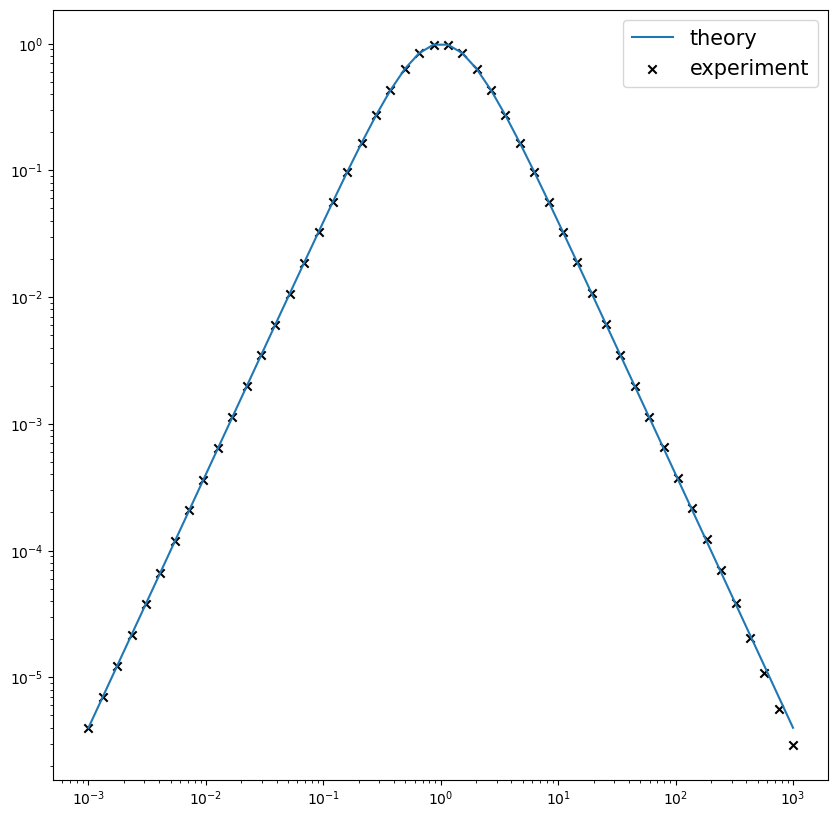

In [13]:
plt.style.use("default")

OUT = np.array(in_snr)/np.array(out_snr)
THR = np.array([alpha(s) for s in slopes])

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plt.yscale("log")
plt.xscale("log")
ax.scatter(slopes, OUT, marker="x", color="black", label="experiment")
ax.plot(slopes, THR, label="theory")
plt.legend(loc='best', fontsize=15)
fig.savefig("figures/LeakyReLU_errors")

# Batch Normalization

In [14]:
import torch.nn as nn

class IBatchNorm2d(nn.BatchNorm2d):
    """
    """
    def __init__(self, *args, ieps=0, invert=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.ieps = ieps
        self.set_invert(invert)
        
    def set_invert(self, invert):
        self.invert = invert
        
    def forward(self, x):
        if self.invert:
            return self.i_forward(x)
        else:
            return super().forward(x)

    def i_forward(self, x):
        with torch.no_grad():
            x_ = x.permute(1,0,2,3).contiguous().view(x.size(1), -1)
            mean, std = x_.mean(1).squeeze(), x_.std(1).squeeze()

        out = F.batch_norm( 
            x, None, None, self.weight.abs() + self.ieps, self.bias, 
            True, 0.0, self.eps
        )

        if self.training and out.requires_grad:
            handle_ref = [0]
            handle_ref_ = out.register_hook(self.get_variable_backward_hook(x, out, std, mean, handle_ref))
            handle_ref[0] = handle_ref_
        x.data.set_()
        return out
        
    def inverse(self, y, x, std, mean):
        with torch.no_grad():
            mean = mean[None,:,None,None]
            var = (std**2)[None,:,None,None]
            bias = self.bias[None,:,None,None]
            weight = self.weight[None,:,None,None]

            x_ = (y-bias)/(weight.abs()+self.ieps) * (var+self.eps).sqrt() + mean
        x.data.set_(x_)
        y.data.set_()

    def get_variable_backward_hook(self, x, output, std, mean, handle_ref):
        def backward_hook(grad):
            self.inverse(output, x, std, mean)
            handle_ref[0].remove()
        return backward_hook

In [15]:
def init_bn_weight(mod, fact=1, nch=1):
    weight = mod.weight.data
    ww = torch.ones_like(weight)
    perm = torch.randperm(100)
    ww[perm<=nch] = ww[perm<=nch]/fact
    weight.set_(ww)

facts = np.linspace(1, 100, 50)
mod   = IBatchNorm2d(ch, invert=False, ieps=0, eps=0).cuda()
noisy_rec = torch.cuda.FloatTensor(0)

out_snr = {}
in_snr  = {}

for ratio in [1, 2, 3]:#, 5, 6]:
    out_snr[ratio] = {}
    in_snr[ratio]  = {}
    for fact in facts:
        init_bn_weight(mod, fact, nch=ch//5)
        inp   = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=1, dist="normal")
        noise = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0., sigma=1*10**-ratio, dist="normal")#.01
        
        with torch.no_grad():
            x_ = inp.permute(1,0,2,3).contiguous().view(inp.size(1), -1)
            mean, std = x_.mean(1).squeeze(), x_.std(1).squeeze()

        out = mod(inp)
        noisy_out = out + noise
        mod.inverse(noisy_out.clone(), noisy_rec, std, mean)
        
        in_snr[ratio][fact]  = f["snr"]((inp, noisy_rec))
        out_snr[ratio][fact] = f["snr"]((out, noisy_out))
        
df = pd.DataFrame(in_snr) / pd.DataFrame(out_snr)
df.index=facts

In [16]:
# Alpha for two parameters
alpha_ = lambda phi, rho_p, rho_n: ( (rho_p + rho_n*(phi**2)) * (rho_p + rho_n/(phi**2)) )**-1

# Alpha for arbitrary bn layer

def alpha_gen(w):
    ww = w.cpu().numpy().flatten()
    ww_sq = ww**2
    nb_ch = ww.size
    alpha = ( ( np.sum(ww_sq)/nb_ch ) * ( np.sum(1/ww_sq)/nb_ch ) )**-1
    return alpha

<AxesSubplot:>

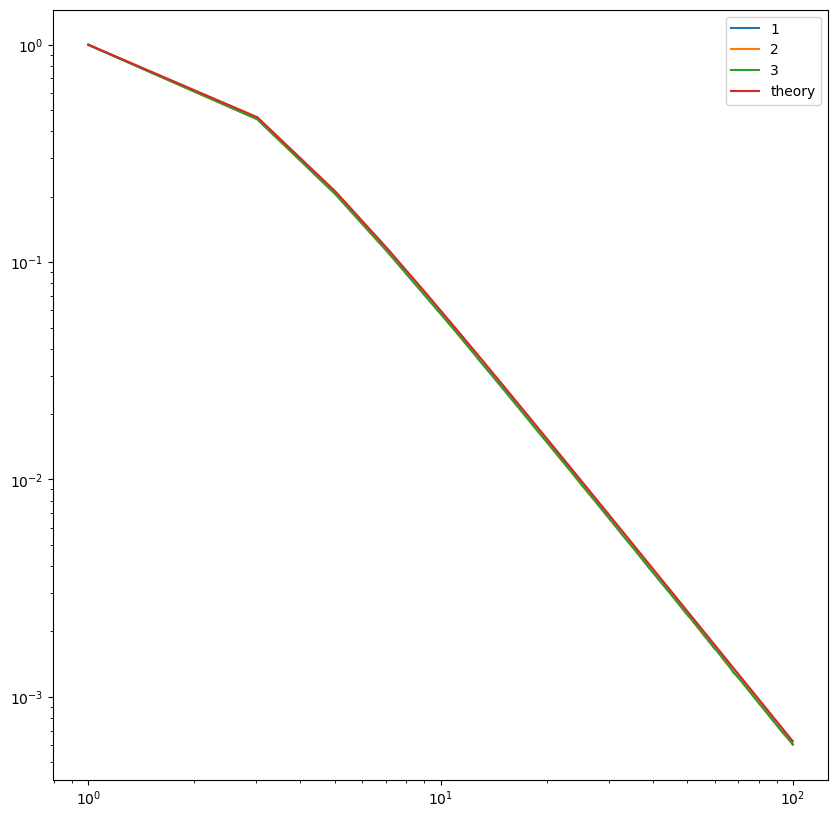

In [17]:
df["theory"]=pd.Series([alpha_((1/s), 0.2, 0.8) for s in facts], index=facts)#.plot(logy=True)
df.plot(logy=True, logx=True, figsize=(10,10))

In [18]:
def init_bn_weight(mod, fact=1, nch=1):
    weight = mod.weight.data
    ww = torch.ones_like(weight)
    perm = torch.randperm(100)
    ww[perm<=nch] = ww[perm<=nch]/fact
    weight.set_(ww)

facts = np.linspace(0, 10, 50)
noisy_rec = torch.cuda.FloatTensor(0)

out_snr = {}
in_snr  = {}
theory = {}
for ratio in [1, 2, 3, 4]:#, 5, 6]:
    out_snr[ratio] = {}
    in_snr[ratio]  = {}
    theory[ratio]  = {}
    for ieps in facts:
        mod   = IBatchNorm2d(ch, invert=False, ieps=0, eps=0).cuda()
        
#         init_bn_weight(mod, fact, nch=ch//5)
#         mod.ieps = ieps
        inp   = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0, sigma=1, dist="normal")
        noise = input_factory(bs=bs, ch=ch, dims=(dim, dim), mu=0., sigma=1*10**-ratio, dist="normal")#.01
        
        with torch.no_grad():
            x_ = inp.permute(1,0,2,3).contiguous().view(inp.size(1), -1)
            mean, std = x_.mean(1).squeeze(), x_.std(1).squeeze()

        out = mod(inp)
        noisy_out = out + noise
        mod.inverse(noisy_out.clone(), noisy_rec, std, mean)
        
        in_snr[ratio][ieps]  = f["snr"]((inp, noisy_rec))
        out_snr[ratio][ieps] = f["snr"]((out, noisy_out))
        theory[ratio][ieps] = alpha_gen( mod.weight.data )

df = pd.DataFrame(in_snr) / pd.DataFrame(out_snr)
df.index=facts

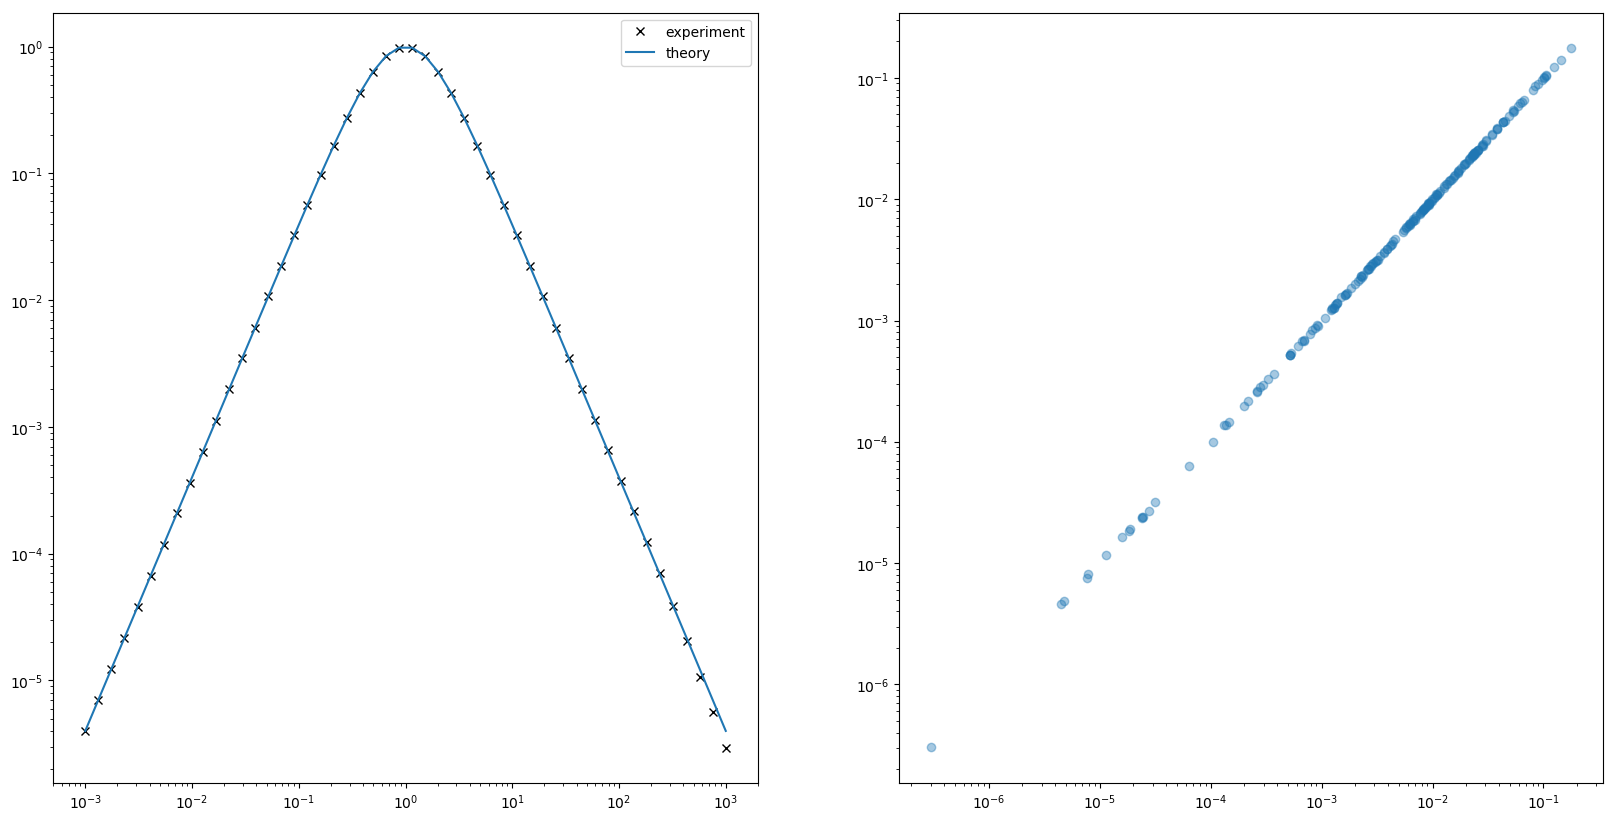

In [100]:
x = [th for th_ in theory.values()
for th in th_.values()]

y = [isnr/osnr for isnr_,osnr_ in zip(in_snr.values(), out_snr.values())
                   for isnr,osnr in zip(isnr_.values(), osnr_.values())]


fig, ax = plt.subplots(1,2, figsize=(20,10))
plt.yscale("log")
plt.xscale("log")

ax[0].loglog(slopes, OUT, marker="x", color="black", label="experiment", linestyle='None')
ax[0].plot(slopes, THR, label="theory")

ax[0].legend()

ax[1].scatter(x, y, alpha=.4)
fig.savefig("bn_error")